In [1]:
# End-to-End Data Analysis Project (Comprehensive, with many visuals)
# This cell generates a realistic synthetic retail dataset, performs EDA, feature engineering,
# segmentation, and simple ML models (regression + classification). It also saves a ready-to-run
# Jupyter notebook (.ipynb) and exports cleaned CSVs for reuse.
#
# Notes for charts:
# - Uses matplotlib only
# - One chart per figure (no subplots)
# - No explicit color styling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from datetime import datetime, timedelta
import os, json, math, io, sys, uuid, random
os.makedirs("/mnt/data/")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

# For building a notebook file to download
import nbformat as nbf

np.random.seed(42)
random.seed(42)


In [3]:
# ==============================
# 1) Generate a synthetic dataset
# ==============================
N_ORDERS = 3500
N_CUSTOMERS = 600

start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 9, 1)
date_range_days = (end_date - start_date).days

customers = [f"C{str(i).zfill(4)}" for i in range(1, N_CUSTOMERS + 1)]
regions = ["North", "South", "East", "West"]
channels = ["Organic", "Paid Search", "Email", "Social", "Affiliate"]
categories = ["Electronics", "Home", "Beauty", "Toys", "Grocery", "Clothing"]

In [4]:
# Base price per category
price_map = {
    "Electronics": (120, 300),
    "Home": (30, 150),
    "Beauty": (10, 60),
    "Toys": (8, 40),
    "Grocery": (3, 20),
    "Clothing": (15, 80),
}

def random_date():
    return start_date + timedelta(days=np.random.randint(0, date_range_days + 1))

def random_price(cat):
    low, high = price_map[cat]
    return np.round(np.random.uniform(low, high), 2)

records = []
for order_id in range(1, N_ORDERS + 1):
    cust = random.choice(customers)
    region = random.choice(regions)
    channel = random.choice(channels)
    category = random.choice(categories)
    order_date = random_date()

    quantity = max(1, np.random.poisson(2))
    unit_price = random_price(category)
    discount = np.clip(np.random.normal(0.12, 0.08), 0.0, 0.5)  # avg 12% discount
    shipping_cost = max(2.0, np.random.normal(6.0 + 0.02 * unit_price * quantity, 1.5))

    order_value = unit_price * quantity * (1 - discount)
    cogs = 0.6 * unit_price * quantity   # 60% of unit price as cost of goods
    profit = order_value - (cogs + shipping_cost)
    is_returned = np.random.rand() < 0.06  # ~6% returns

    records.append({
        "order_id": f"O{order_id:05d}",
        "customer_id": cust,
        "order_date": order_date,
        "region": region,
        "channel": channel,
        "category": category,
        "quantity": quantity,
        "unit_price": unit_price,
        "discount": np.round(discount, 3),
        "shipping_cost": np.round(shipping_cost, 2),
        "order_value": np.round(order_value, 2),
        "cogs": np.round(cogs, 2),
        "profit": np.round(profit, 2),
        "is_returned": int(is_returned),
    })

df = pd.DataFrame(records)


In [5]:
# Introduce some missingness (~2-3% in discount and shipping)
for col in ["discount", "shipping_cost"]:
    mask = np.random.rand(len(df)) < 0.025
    df.loc[mask, col] = np.nan

# Derived columns
df["profit_margin"] = np.where(df["order_value"] > 0, df["profit"] / df["order_value"], 0.0)

# Save raw synthetic dataset
raw_csv_path = "/mnt/data/synthetic_retail_orders.csv"
df.to_csv(raw_csv_path, index=False)


In [6]:
# ==============================
# 2) Basic EDA
# ==============================
print("### Basic Info")
print(df.info())

### Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       3500 non-null   object        
 1   customer_id    3500 non-null   object        
 2   order_date     3500 non-null   datetime64[ns]
 3   region         3500 non-null   object        
 4   channel        3500 non-null   object        
 5   category       3500 non-null   object        
 6   quantity       3500 non-null   int64         
 7   unit_price     3500 non-null   float64       
 8   discount       3407 non-null   float64       
 9   shipping_cost  3403 non-null   float64       
 10  order_value    3500 non-null   float64       
 11  cogs           3500 non-null   float64       
 12  profit         3500 non-null   float64       
 13  is_returned    3500 non-null   int64         
 14  profit_margin  3500 non-null   float64       
dtypes: dat

In [7]:
print("\n### Describe (numeric)")
print(df.describe().T)


### Describe (numeric)
                count                           mean                  min  \
order_date       3500  2024-05-06 15:52:02.742857216  2023-01-01 00:00:00   
quantity       3500.0                       2.149429                  1.0   
unit_price     3500.0                      71.184791                 3.01   
discount       3407.0                       0.122058                  0.0   
shipping_cost  3403.0                       9.084643                  2.0   
order_value    3500.0                     134.362074                 2.19   
cogs           3500.0                      92.038871                 1.88   
profit         3500.0                      33.235906                -8.56   
is_returned    3500.0                       0.064857                  0.0   
profit_margin  3500.0                       0.113944            -3.908676   

                               25%                  50%                  75%  \
order_date     2023-09-14 00:00:00  2024-05-14 0

In [8]:
print("\n### Missing Values (% of rows)")
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print(missing_pct.round(2))


### Missing Values (% of rows)
shipping_cost    2.77
discount         2.66
order_id         0.00
region           0.00
channel          0.00
customer_id      0.00
order_date       0.00
quantity         0.00
category         0.00
unit_price       0.00
order_value      0.00
cogs             0.00
profit           0.00
is_returned      0.00
profit_margin    0.00
dtype: float64


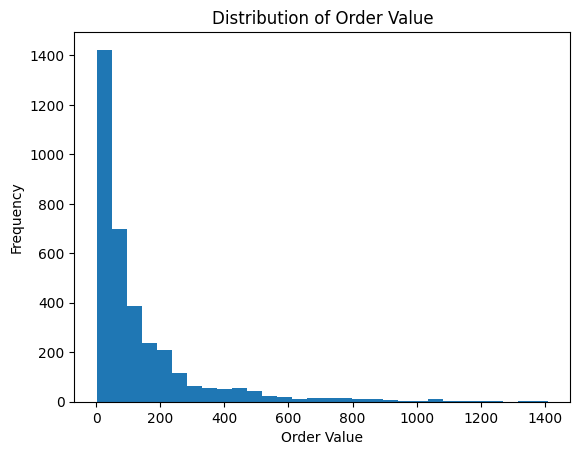

In [9]:
# ==============================
# 3) Visual EDA (Matplotlib only)
# ==============================

# 3.1 Distribution of order_value
plt.figure()
plt.hist(df["order_value"].dropna(), bins=30)
plt.title("Distribution of Order Value")
plt.xlabel("Order Value")
plt.ylabel("Frequency")
plt.show()

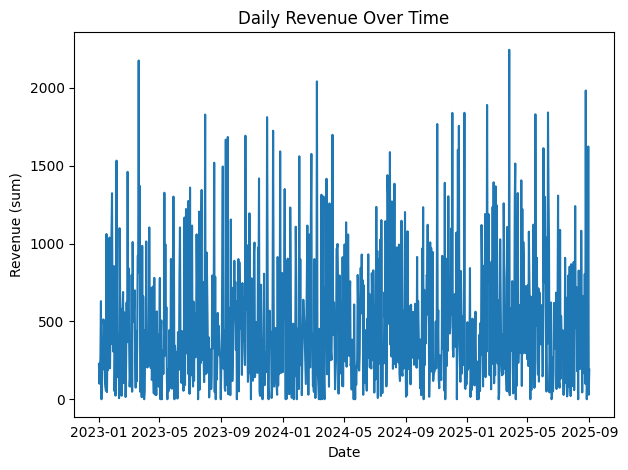

In [10]:
# 3.2 Revenue over time (daily)
daily_rev = df.set_index("order_date")["order_value"].resample("D").sum()
plt.figure()
plt.plot(daily_rev.index, daily_rev.values)
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue (sum)")
plt.tight_layout()
plt.show()

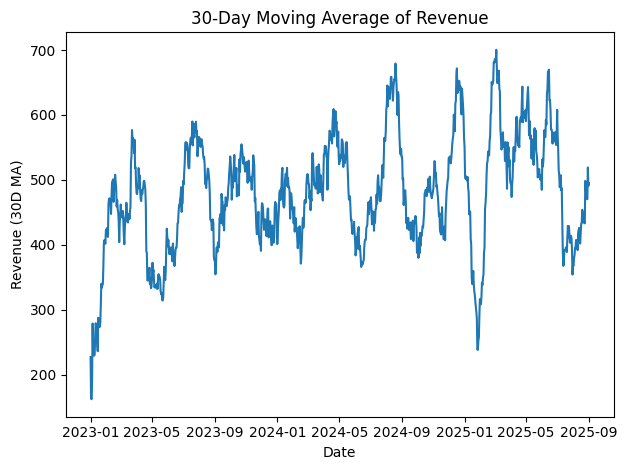

In [11]:
# 3.3 30-day moving average of revenue
ma30 = daily_rev.rolling(30, min_periods=1).mean()
plt.figure()
plt.plot(ma30.index, ma30.values)
plt.title("30-Day Moving Average of Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue (30D MA)")
plt.tight_layout()
plt.show()

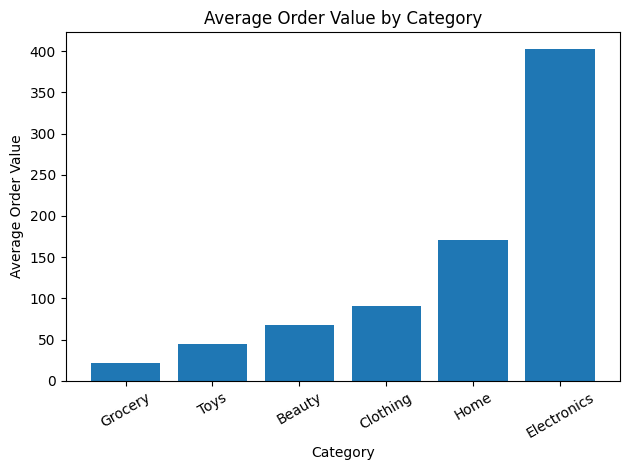

In [12]:
# 3.4 Average order value by category
aov_by_cat = df.groupby("category")["order_value"].mean().sort_values()
plt.figure()
plt.bar(aov_by_cat.index, aov_by_cat.values)
plt.title("Average Order Value by Category")
plt.xlabel("Category")
plt.ylabel("Average Order Value")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1606317427.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=categories, vert=True)


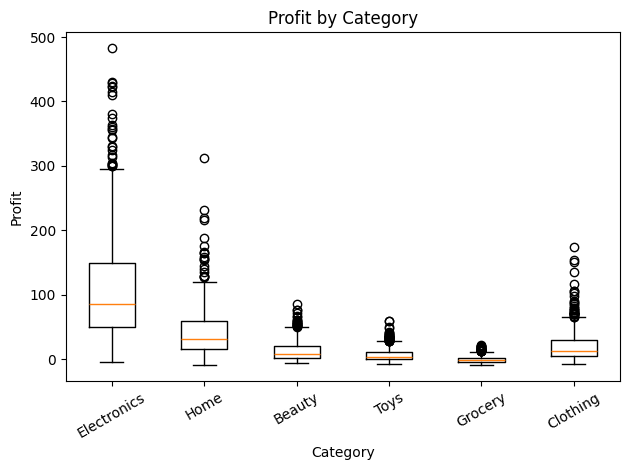

In [13]:
# 3.5 Profit by category (boxplot)
plt.figure()
data_to_plot = [df.loc[df["category"] == cat, "profit"].dropna() for cat in categories]
plt.boxplot(data_to_plot, labels=categories, vert=True)
plt.title("Profit by Category")
plt.xlabel("Category")
plt.ylabel("Profit")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

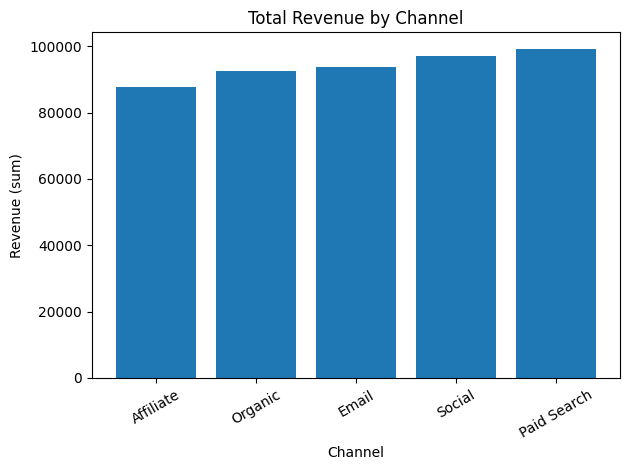

In [14]:
# 3.6 Revenue by channel
rev_by_channel = df.groupby("channel")["order_value"].sum().sort_values()
plt.figure()
plt.bar(rev_by_channel.index, rev_by_channel.values)
plt.title("Total Revenue by Channel")
plt.xlabel("Channel")
plt.ylabel("Revenue (sum)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


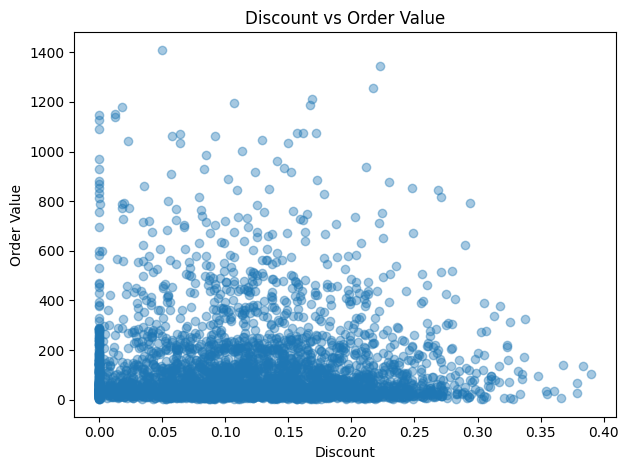

In [15]:
# 3.7 Discount vs Order Value (scatter)
plt.figure()
plt.scatter(df["discount"], df["order_value"], alpha=0.4)
plt.title("Discount vs Order Value")
plt.xlabel("Discount")
plt.ylabel("Order Value")
plt.tight_layout()
plt.show()

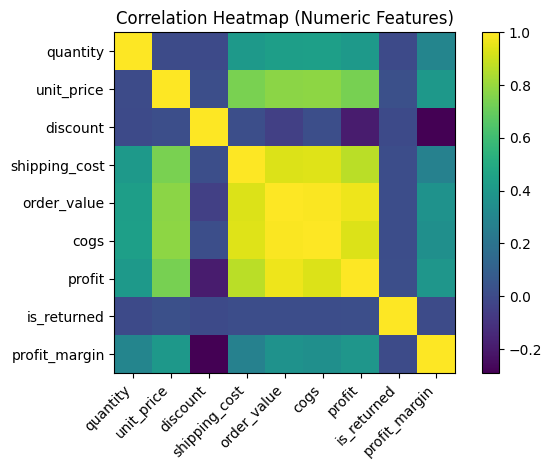

In [16]:
# 3.8 Correlation heatmap (numeric cols)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()
plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap (Numeric Features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

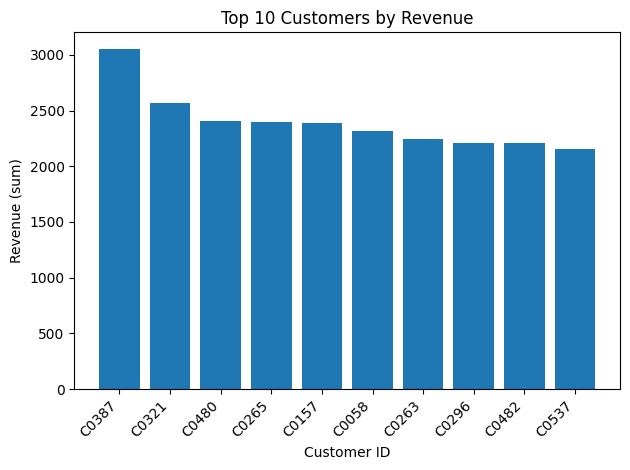

In [17]:
# 3.9 Top 10 customers by revenue
top_customers = df.groupby("customer_id")["order_value"].sum().sort_values(ascending=False).head(10)
plt.figure()
plt.bar(top_customers.index, top_customers.values)
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Revenue (sum)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


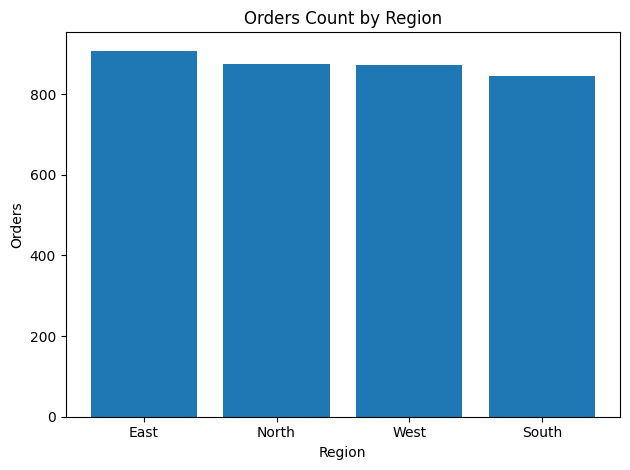

In [18]:
# 3.10 Orders count by region
count_by_region = df["region"].value_counts()
plt.figure()
plt.bar(count_by_region.index, count_by_region.values)
plt.title("Orders Count by Region")
plt.xlabel("Region")
plt.ylabel("Orders")
plt.tight_layout()
plt.show()


In [19]:
# ==============================
# 4) Data Cleaning
# ==============================

# Impute missing with medians for numeric columns
df_clean = df.copy()
for col in ["discount", "shipping_cost"]:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Ensure types
df_clean["order_date"] = pd.to_datetime(df_clean["order_date"])

clean_csv_path = "/mnt/data/cleaned_orders.csv"
df_clean.to_csv(clean_csv_path, index=False)


In [20]:
# ==============================
# 5) Feature Engineering
# ==============================

# Example: RFM per customer
snapshot_date = df_clean["order_date"].max() + pd.Timedelta(days=1)
rfm = df_clean.groupby("customer_id").agg(
    recency = ("order_date", lambda x: (snapshot_date - x.max()).days),
    frequency = ("order_id", "count"),
    monetary = ("order_value", "sum")
).reset_index()

In [21]:
# Normalize (z-score) for clustering
rfm_features = rfm[["recency", "frequency", "monetary"]].copy()
rfm_scaled = (rfm_features - rfm_features.mean()) / rfm_features.std(ddof=0)

# KMeans clustering (3 segments)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
rfm["segment"] = kmeans.fit_predict(rfm_scaled)

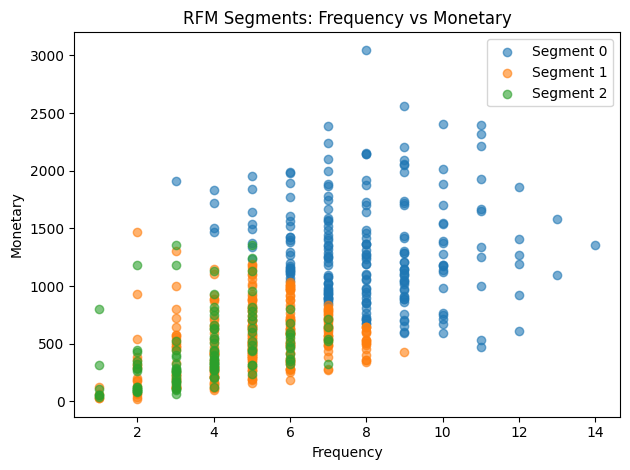

In [22]:
# Visualize Frequency vs Monetary colored by segment (separate scatter calls, default colors)
plt.figure()
for seg in sorted(rfm["segment"].unique()):
    sub = rfm[rfm["segment"] == seg]
    plt.scatter(sub["frequency"], sub["monetary"], alpha=0.6, label=f"Segment {seg}")
plt.title("RFM Segments: Frequency vs Monetary")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.legend()
plt.tight_layout()
plt.show()



### Linear Regression Performance
R^2: 0.9093 | RMSE: 58.62


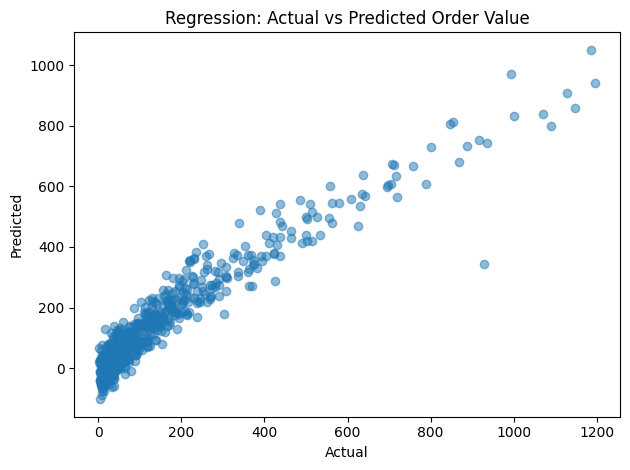


### Logistic Regression Performance (High-Value Orders)
Accuracy: 0.967 | Precision: 0.940 | Recall: 0.893 | ROC-AUC: 0.995


In [23]:
# ==============================
# 6) Predictive Modeling
# ==============================

# 6.a) Regression: Predict order_value
model_df = df_clean.copy()
X = model_df[["quantity", "discount", "unit_price", "shipping_cost", "is_returned", "profit_margin"]]
X = pd.concat([
    X,
    pd.get_dummies(model_df[["region", "channel", "category"]], drop_first=True)
], axis=1)
y = model_df["order_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n### Linear Regression Performance\nR^2: {r2:.4f} | RMSE: {rmse:.2f}")

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Regression: Actual vs Predicted Order Value")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

# 6.b) Classification: Predict high-value orders (top 20%)
threshold = np.quantile(df_clean["order_value"], 0.80)
clf_df = model_df.copy()
clf_df["high_value"] = (clf_df["order_value"] >= threshold).astype(int)

Xc = clf_df[["quantity", "discount", "unit_price", "shipping_cost", "is_returned", "profit_margin"]]
Xc = pd.concat([
    Xc,
    pd.get_dummies(clf_df[["region", "channel", "category"]], drop_first=True)
], axis=1)
yc = clf_df["high_value"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)

scaler = StandardScaler(with_mean=False)  # sparse-safe
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xc_train_scaled, yc_train)
yc_pred = logreg.predict(Xc_test_scaled)
yc_prob = logreg.predict_proba(Xc_test_scaled)[:, 1]

acc = accuracy_score(yc_test, yc_pred)
prec = precision_score(yc_test, yc_pred)
rec = recall_score(yc_test, yc_pred)
auc = roc_auc_score(yc_test, yc_prob)

print(f"\n### Logistic Regression Performance (High-Value Orders)\nAccuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | ROC-AUC: {auc:.3f}")


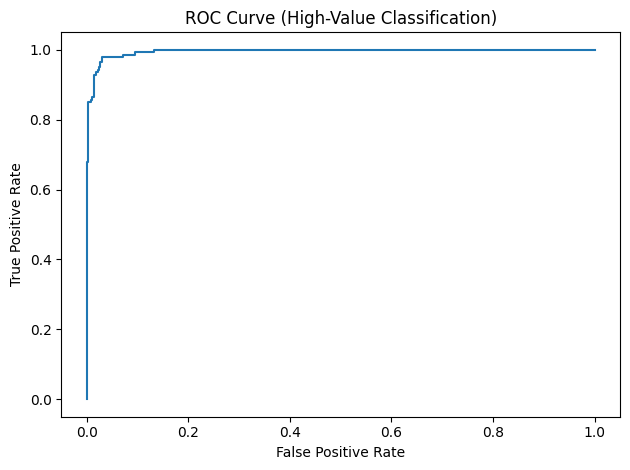

In [24]:
# ROC curve
fpr, tpr, _ = roc_curve(yc_test, yc_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC Curve (High-Value Classification)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

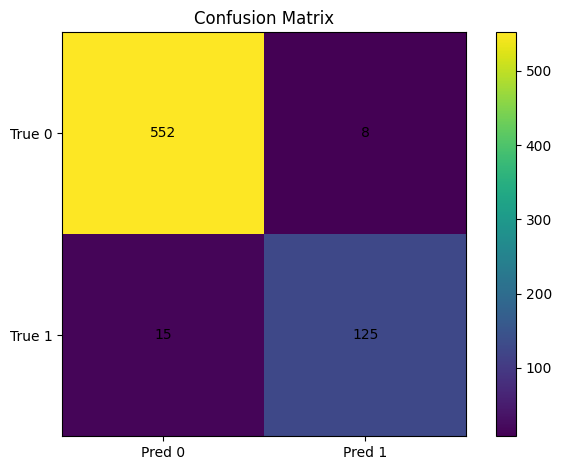

In [25]:
# Confusion matrix
cm = confusion_matrix(yc_test, yc_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()